<a href="https://colab.research.google.com/github/Jul-Summer/HW_PY13Visual_Churn/blob/main/Copy_of_%D0%9A%D0%BE%D0%BC%D0%BF%D0%B8%D0%BB%D1%8F%D1%86%D0%B8%D1%8F_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D0%B5%D0%B9_%D0%B2_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Runtime → Change runtime type → Hardware accelerator → GPU


In [ ]:
#Проверка, что GPU действительно работает
import tensorflow as tf
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#Это значит: GPU подключён, можно обучать модели
#[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#Следующий шаг №1 (рекомендую):
#Запустить MNIST код целиком и посмотреть, как быстро обучается модель на GPU.

In [ ]:
#Загрузка и подготовка данных (MNIST)
#Что здесь происходит
#tensorflow — фреймворк
#keras — высокоуровневый API
#Sequential — простой способ собирать модель слоями

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Sequential, layers, losses, optimizers


In [ ]:
#Загрузка датасета MNIST
#📌 MNIST:
#60 000 обучающих изображений
#10 000 тестовых
#каждое изображение: 28×28 пикселей
#значения пикселей: 0–255

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()




11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#Приведение данных к виду, удобному для нейросети
#Очень важно понять это 👇
#reshape(-1, 28*28)
#нейросеть Dense не понимает 2D-картинки
#мы превращаем картинку 28×28 → в вектор из 784 чисел
#/ 255
#нормализация
#теперь значения пикселей ∈ [0, 1]
#без этого обучение часто ломается

X_train = X_train.reshape(-1, 28*28) / 255
X_test = X_test.reshape(-1, 28*28) / 255



In [ ]:
#Проверка данных
#Ты должен увидеть:
#(60000, 784)
#(10000, 784)
#метки — числа от 0 до 9

print(X_train.shape, X_train.dtype)
print(X_test.shape, X_test.dtype)

print(y_train.shape, y_train[:10])
print(y_test.shape, y_test[:10])




(60000, 784) float64
(10000, 784) float64
(60000,) [5 0 4 1 9 2 1 3 1 4]
(10000,) [7 2 1 0 4 1 4 9 5 9]


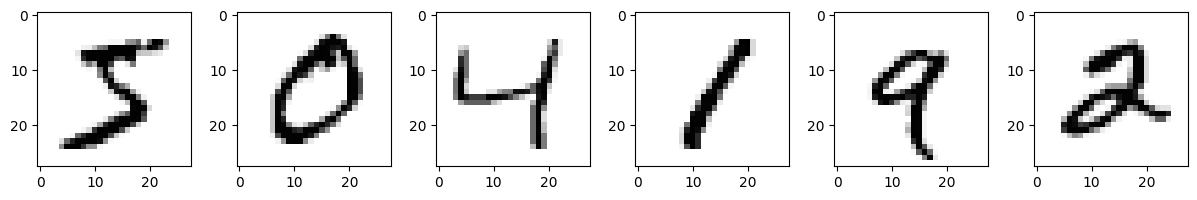

In [ ]:
#Визуализация изображений
#📌 Это очень хорошая практика — всегда смотреть на данные глазами.
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 6, figsize=(15, 2))
for img, ax in zip(X_train, axes.flat):
    ax.imshow(img.reshape(28, 28), cmap='Greys')
plt.show()




In [ ]:
#Создание модели (архитектура)


from tensorflow.keras import layers, Sequential

model = Sequential([
    layers.InputLayer(input_shape=(28*28,)),  # <-- кортеж, даже если один размер; InputLayer ожидает кортеж формы (tuple) для input_shape, а не число.
    layers.Dense(500, activation='relu'),
    layers.Dense(500, activation='relu'),
    layers.Dense(10, activation='softmax')  # например, для классификации 10 классов
])



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Ключевые моменты:

input_shape=(784,), а не просто 784.

Используем activation='relu' в Dense, нельзя просто писать 'relu' вторым аргументом.

Последний слой зависит от задачи (классов).
Что это за модель
784 → 500 → 500 → 10


Dense(500, relu) — полносвязный слой

Dense(10) — 10 классов (цифры 0–9)

softmax нет → значит выход = logits

Что такое logits и почему это нормально

logits = «сырые» выходы сети

softmax применяется внутри функции потерь

это:

численно стабильнее

стандартная практика

In [ ]:
#Компиляция модели
#Разбор по пунктам
#SparseCategoricalCrossentropy
#потому что метки — числа, а не one-hot

#from_logits=True — потому что нет softmax

#Adam - лучший дефолт-оптимизатор,почти всегда начинать с него — правильно


model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizers.Adam(),
    metrics=['accuracy'] # Keras не позволяет передавать одну строку  ('accuracy'),
                         #потому что внутренне он обрабатывает метрики как коллекцию.
                         #Даже если у вас только одна метрика, её нужно обернуть в список ['accuracy']
)

# просто сделайте метрику списком: metrics=['accuracy']

In [ ]:
#If you want to track multiple metrics, you can do:(Если вы хотите отслеживать несколько метрик:)
#model.compile(
 #   loss=losses.SparseCategoricalCrossentropy(from_logits=True),
 #   optimizer=optimizers.Adam(),
  #  metrics=['accuracy', 'Precision', 'Recall']
#)

#Исправленный вариант твоей компиляции:
from tensorflow.keras import losses, optimizers
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=optimizers.Adam(),
    metrics=['accuracy', Precision(), Recall()]
)


Почему Keras требует список:
Keras спроектирован для работы с множественными выходами модели. Даже если сейчас у вашей модели только один выход, metrics всегда ожидает коллекцию, потому что в будущем это может быть список метрик для каждого выхода.
По сути, даже одна метрика должна быть списком, чтобы код оставался универсальным для любых моделей.

In [ ]:
#Обучение модели (fit)
#Что тут реально происходит
#epochs=10 → 10 полных проходов по данным
#batch_size=1024
#60000 / 1024 ≈ 59 шагов
#после каждой эпохи:
#loss
#accuracy
#val_loss
#val_accuracy

model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=1024
)



Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd_1 defined at (most recent call last):
<stack traces unavailable>
Incompatible shapes: [1,1024] vs. [1,10240]
	 [[{{node LogicalAnd_1}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_3610[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_multi_step_on_iterator_3673]

In [ ]:
#Проверь форму меток:

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [ ]:
#Убедись, что Dense на выходе совпадает с количеством классов:

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import losses, optimizers
from tensorflow.keras.metrics import Precision, Recall

num_classes = len(np.unique(y_train))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
#Настрой функцию потерь корректно:

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [ ]:
#Если метки one-hot, используй categorical_crossentropy:

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

In [ ]:
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=1024
)


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node LogicalAnd_1 defined at (most recent call last):
<stack traces unavailable>
Incompatible shapes: [1,1024] vs. [1,10240]
	 [[{{node LogicalAnd_1}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_3610[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_multi_step_on_iterator_3673]

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# -------------------------
# 1. Пример данных
# -------------------------
# Допустим, у нас 1024 признака и 10 классов
num_features = 1024
num_classes = 10
num_samples = 1000

# Случайные данные
X_train = np.random.rand(num_samples, num_features).astype(np.float32)
y_train = np.random.randint(0, num_classes, size=(num_samples,))  # метки 0..9
X_test = np.random.rand(200, num_features).astype(np.float32)
y_test = np.random.randint(0, num_classes, size=(200,))

# -------------------------
# 2. Построение модели
# -------------------------
model = Sequential([
    Input(shape=(num_features,)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')  # последний слой совпадает с числом классов
])

# -------------------------
# 3. Компиляция модели
# -------------------------
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(from_logits=False),  # softmax уже есть
    metrics=['accuracy']
)

# -------------------------
# 4. Обучение модели
# -------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.0916 - loss: 2.4889 - val_accuracy: 0.1150 - val_loss: 2.3153
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1571 - loss: 2.2909 - val_accuracy: 0.0950 - val_loss: 2.3960
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1713 - loss: 2.2495 - val_accuracy: 0.0700 - val_loss: 2.3949
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1997 - loss: 2.2143 - val_accuracy: 0.0800 - val_loss: 2.4501
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2714 - loss: 2.1278 - val_accuracy: 0.0900 - val_loss: 2.4557
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2748 - loss: 2.0416 - val_accuracy: 0.0900 - val_loss: 2.4871
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4133 - loss: 1.8571 - val_accuracy: 0.0950 - val_loss: 2.5358
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5215 - loss: 1.6344 - val_accuracy: 0.0900 - val_loss

Основные исправления

from_logits=False → потому что на выходе уже Softmax.

Dense(num_classes, activation='softmax') → выходной слой соответствует числу классов.

Метки y_train и y_test — целые числа (для SparseCategoricalCrossentropy).

Batch size и input shape совпадают с данными.

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

# 1. Данные
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# one-hot для categorical_crossentropy
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# 2. Модель
model = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(500, activation='relu'),
    Dense(500, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 3. Обучение
history = model.fit(x_train, y_train_cat,
                    validation_data=(x_test, y_test_cat),
                    epochs=10,
                    batch_size=32)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9035 - loss: 0.3119 - val_accuracy: 0.9685 - val_loss: 0.0951
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9756 - loss: 0.0796 - val_accuracy: 0.9716 - val_loss: 0.0876
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9832 - loss: 0.0515 - val_accuracy: 0.9738 - val_loss: 0.0857
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9873 - loss: 0.0385 - val_accuracy: 0.9763 - val_loss: 0.0845
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9896 - loss: 0.0313 - val_accuracy: 0.9800 - val_loss: 0.0769
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9913 - loss: 0.0271 - val_accuracy: 0.9814 - val_loss: 0.0746
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9938 - loss: 0.0194 - val_accuracy: 0.9796 - val_loss: 0.0820
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9940 - loss: 0.0202 - 

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]


In [ ]:
#Обучение модели
#Можно использовать один вызов .fit() с callbacks:

history = model.fit(
    x_train, y_train_cat,
    validation_data=(x_test, y_test_cat),
    epochs=50,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9983 - loss: 0.0061
Epoch 1: val_accuracy improved from -inf to 0.98530, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9983 - loss: 0.0061 - val_accuracy: 0.9853 - val_loss: 0.0593 - learning_rate: 0.0010
Epoch 2/50
460/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 7.2751e-04
Epoch 2: val_accuracy improved from 0.98530 to 0.98550, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9999 - loss: 7.2575e-04 - val_accuracy: 0.9855 - val_loss: 0.0651 - learning_rate: 0.0010
Epoch 3/50
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.3810e-04
Epoch 3: val_accuracy improved from 0.98550 to 0.98620, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 3.3755e-04 - val_accuracy: 0.9862 - val_loss: 0.0651 - learning_rate: 0.0010
Epoch 4/50
450/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.4760e-04
Epoch 4: val_accuracy did not improve from 0.98620

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: 1.4787e-04 - val_accuracy: 0.9862 - val_loss: 0.0691 - learning_rate: 0.0010
Epoch 5/50
458/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.9652e-05
Epoch 5: val_accuracy did not improve from 0.98620
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 1.0000 - loss: 7.9659e-05 - val_accuracy: 0.9859 - val_loss: 0.0733 - learning_rate: 5.0000e-04
Epoch 6/50
463/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.2601e-05
Epoch 6: val_accuracy did not improve from 0.98620
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 -

In [ ]:
#Получение предсказаний
# Предсказания вероятностей
y_pred_probs = model.predict(x_test, batch_size=128)

# Предсказания классов
y_pred_classes = y_pred_probs.argmax(axis=1)

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
#Оценка модели
loss, accuracy = model.evaluate(x_test, y_test_cat, batch_size=128)
print(f"Test accuracy: {accuracy:.4f}, Test loss: {loss:.4f}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9824 - loss: 0.0994
Test accuracy: 0.9860, Test loss: 0.0763


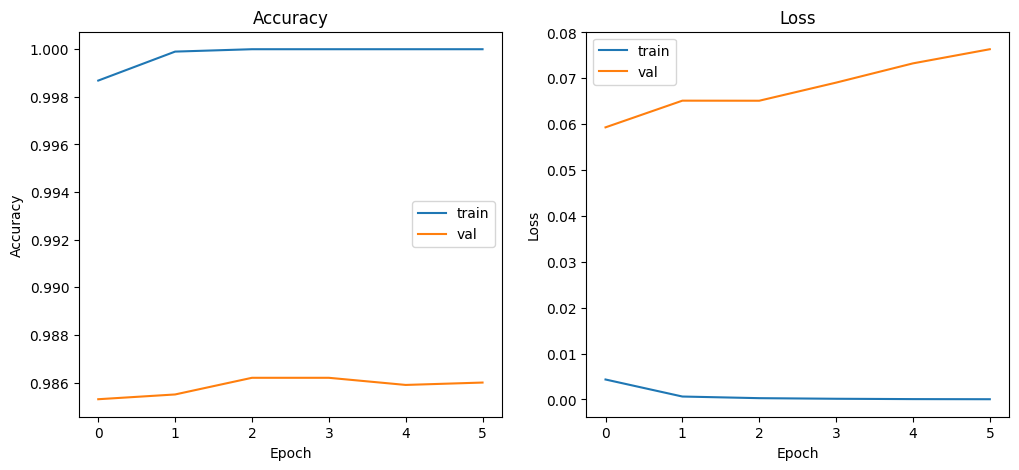

In [ ]:
#Визуализация кривых обучения
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8823 - loss: 0.3960
Epoch 1: val_accuracy improved from -inf to 0.96840, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8824 - loss: 0.3956 - val_accuracy: 0.9684 - val_loss: 0.1025
Test accuracy after epoch 1: 0.9684

Epoch 2/10
460/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9756 - loss: 0.0782
Epoch 1: val_accuracy improved from 0.96840 to 0.97390, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9756 - loss: 0.0782 - val_accuracy: 0.9739 - val_loss: 0.0848
Test accuracy after epoch 2: 0.9739

Epoch 3/10
450/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9833 - loss: 0.0510
Epoch 1: val_accuracy improved from 0.97390 to 0.97810, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9833 - loss: 0.0510 - val_accuracy: 0.9781 - val_loss: 0.0689
Test accuracy after epoch 3: 0.9781

Epoch 4/10
461/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9894 - loss: 0.0331
Epoch 1: val_accuracy improved from 0.97810 to 0.98180, saving model to best_model.h5


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9894 - loss: 0.0332 - val_accuracy: 0.9818 - val_loss: 0.0608
Test accuracy after epoch 4: 0.9818

Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9931 - loss: 0.0225
Epoch 1: val_accuracy did not improve from 0.98180
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9931 - loss: 0.0225 - val_accuracy: 0.9793 - val_loss: 0.0726
Test accuracy after epoch 5: 0.9793

Epoch 6/10
455/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0182
Epoch 1: val_accuracy did not improve from 0.98180
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9941 - loss: 0.0183 - val_accuracy: 0.9806 - val_loss: 0.0743
Test accuracy after epoch 6: 0.9806

Epoch 7/10
467/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9946 - loss: 0.0164
Epoch 1: val_accuracy did not improve from 0.98180
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9946 - loss: 0.0164 - val_accuracy: 0.9800 - val_loss: 0.0725
Test accur

469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9954 - loss: 0.0136 - val_accuracy: 0.9830 - val_loss: 0.0723
Test accuracy after epoch 8: 0.9830

Epoch 9/10
465/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0153
Epoch 1: val_accuracy did not improve from 0.98300
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9952 - loss: 0.0153 - val_accuracy: 0.9805 - val_loss: 0.0810
Test accuracy after epoch 9: 0.9805

Epoch 10/10
459/469 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9957 - loss: 0.0118
Epoch 1: val_accuracy did not improve from 0.98300
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9957 - loss: 0.0118 - val_accuracy: 0.9792 - val_loss: 0.0795
Test accuracy after epoch 10: 0.9792


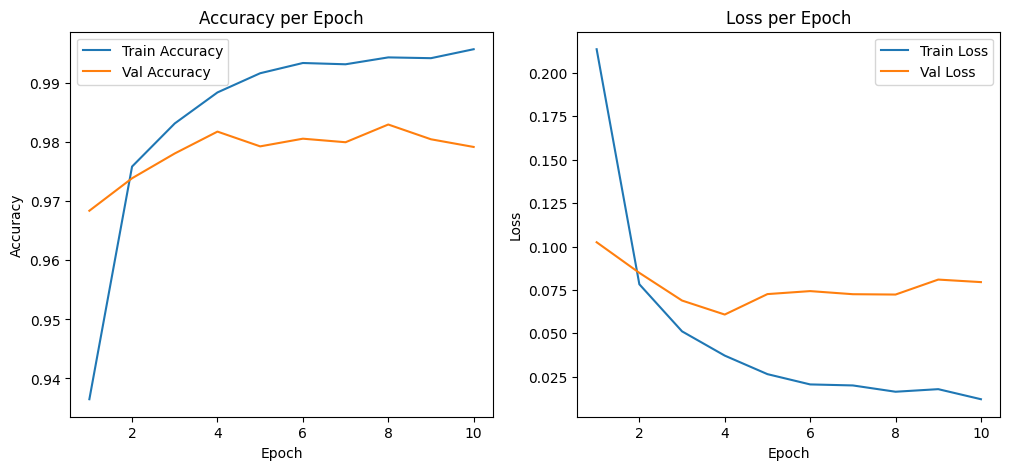

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 1. Загрузка данных
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# 2. Создание модели
model = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(500, activation='relu'),
    Dense(500, activation='relu'),
    Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 3. Callbacks (по желанию)
callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1)
]

# 4. Цикл обучения по одной эпохе + сбор предсказаний и метрик
num_epochs = 10
history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}
predictions_history = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # обучаем 1 эпоху
    hist = model.fit(x_train, y_train_cat, epochs=1, batch_size=128,
                     validation_data=(x_test, y_test_cat), verbose=1, callbacks=callbacks)

    # сохраняем метрики
    history['accuracy'].append(hist.history['accuracy'][0])
    history['val_accuracy'].append(hist.history['val_accuracy'][0])
    history['loss'].append(hist.history['loss'][0])
    history['val_loss'].append(hist.history['val_loss'][0])

    # делаем предсказания на тесте
    y_pred = model.predict(x_test, batch_size=128, verbose=0)
    predictions_history.append(y_pred)

    # можно оценить точность на тесте
    test_acc = np.mean(np.argmax(y_pred, axis=1) == y_test)
    print(f"Test accuracy after epoch {epoch+1}: {test_acc:.4f}")

# 5. Визуализация прогресса
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(range(1,num_epochs+1), history['accuracy'], label='Train Accuracy')
plt.plot(range(1,num_epochs+1), history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(range(1,num_epochs+1), history['loss'], label='Train Loss')
plt.plot(range(1,num_epochs+1), history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.show()
